# Purpose
The purpose of this notebook is to check some of the math that is used throughout to ensure (visually) that it is doing what I think it is doing.  We won't be checking the basic math operations, or other things that are easily checked in the unit tests.

First, we'll do our normal imports, and add the first two lines that form our initial test application.  From there, we'll walk through step-by-step the major parts of the math the application depends on:

1. Calculation of the normal vectors
1. Ray-casting
1. Hit determination

#### Calculation of the normal vectors

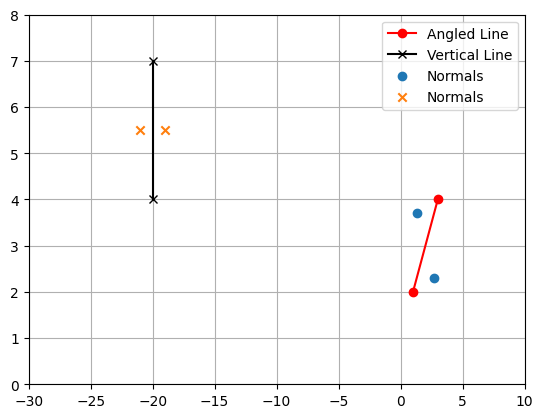

In [118]:
import math
import matplotlib.pyplot as plt
import numpy as np


class Point2D(object):
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __add__(self, other):
        return Point2D(self.x + other.x, self.y + other.y)


class Line2D(object):
    def __normalize_point(p: Point2D) -> Point2D:
        # TODO: Should do this in the simulation code.
        mag = math.sqrt((p.x * p.x) + (p.y * p.y))
        return Point2D(p.x / mag, p.y / mag)

    def __init__(self, p1: Point2D, p2: Point2D):
        self.p1 = p1
        self.p2 = p2
        self.midpoint: Point2D = Point2D((p1.x + p2.x) / 2.0, (p1.y + p2.y) / 2.0)

        dy = p2.y - p1.y
        dx = p2.x - p1.x
        self.normals: list[Point2D] = [Point2D(-dy, dx), Point2D(dy, -dx)]
        self.normals = [Line2D.__normalize_point(x) for x in self.normals]

        self.ref_translated_normals: list[Point2D] = [
            self.normals[0] + self.midpoint,
            self.normals[1] + self.midpoint,
        ]


def plot_line(line: Line2D, marker: str, color: str):
    plt.plot([line.p1.x, line.p2.x], [line.p1.y, line.p2.y], marker=marker, color=color)


line1 = Line2D(Point2D(1.0, 2.0), Point2D(3.0, 4.0))
line2 = Line2D(Point2D(-20.0, 4.0), Point2D(-20.0, 7.0))

ax = plt.gca()
plt.grid(True)
ax.set_xlim([-30, 10])
ax.set_ylim([0, 8])

plot_line(line1, marker="o", color="red")
plot_line(line2, marker="x", color="black")

plt.scatter(
    [x.x for x in line1.ref_translated_normals],
    [y.y for y in line1.ref_translated_normals],
    marker="o",
)

plt.scatter(
    [x.x for x in line2.ref_translated_normals],
    [y.y for y in line2.ref_translated_normals],
    marker="x",
)

plt.legend(["Angled Line", "Vertical Line", "Normals", "Normals"])

plt.show()

##### Notes on the initial plot
Depending on how you set up the plot--the normals (particularly for the angled line) appear to be skewed.  However, if you adjust the plot enough you can show that they are in the correct location.

If we form a vector from from $P_1$ to $P_2$ via ($P_2 - P_1$), we can find a generalized 2d rotation of 90 degrees (since the normal should be perpindicular to the line) via:
$$
x' = x\cos{\theta} - y\sin{\theta}
$$
$$
y' = x\sin{\theta} + y\cos{\theta}
$$

Then, realizing that $\cos{90}$ is $0$ and $\sin{90}$ is $1$,

$$
x' = -y
$$
$$
y' = x
$$

This gives us our first normal of $(-dy, dx)$.  However, every line potentially has two normals--one at 90 degrees, and one at 270 degrees.  Plugging in $\theta=270$ in the aforementioned equations, and remembering that $\cos{270}$ is $0$ and $\sin{270}$ is $-1$:

$$
x' = y
$$
$$
y' = -x
$$

This gives us the second normal of $(dy, -dx)$

One final note, on the plot I do shift the normals to the midpoint of the line.

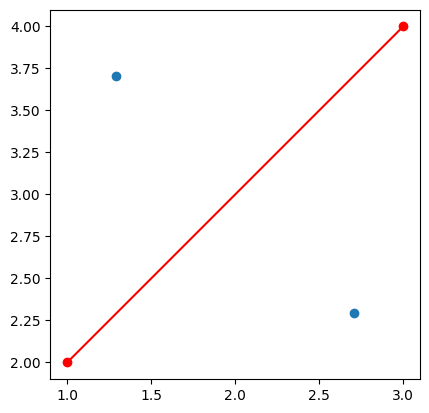

In [119]:
# Just a quick plot of the normals on the angled line to prove that they're where you think
plt.plot()
plot_line(line1, marker="o", color="red")
plt.scatter(
    [x.x for x in line1.ref_translated_normals],
    [y.y for y in line1.ref_translated_normals],
    marker="o",
)
plt.gca().set_aspect("equal")
plt.show()

#### Raycasting
In order to calculate the view factor, we randomly generate $N$ rays, which we then forward propagate to see which shape they hit first.  The random parameters of the ray are the origin $O$, and the angle $\theta$.  The origin is randomly selected along the shape:

$$
P_1 \le O \le P_2
$$

The angle is chosen based on the angle to the associated normal $\pm 90 \deg$ - that is, for a vertical line we would have:

$$
-90 \le \theta_1 \le 90
$$
$$
90 \le \theta_2 \le 270
$$

Where the angle of normal 1, $\vec{N}_1$, is at $0\deg$ and $\vec{N}_2$ is at $180\deg$.  In the code sample below, I have taken some points generated by the simulation alongside with some hand-crafted values to check that we are doing the right thing.

2.3788886,3.3788888 --> 2.003088702690386, 4.305589634780072
1.6721303,2.6721303 --> 1.9467117017368873, 3.633694158420337
2.3788886,3.3788888 --> 3.0206895062847012, 2.612017496134654
1.6721303,2.6721303 --> 1.0285017042348614, 1.906792315372688


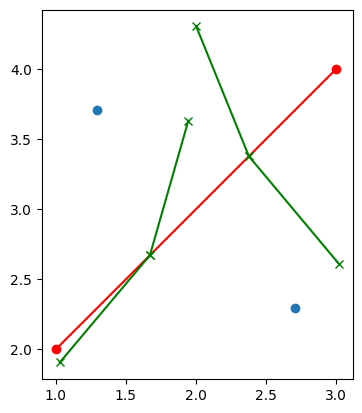

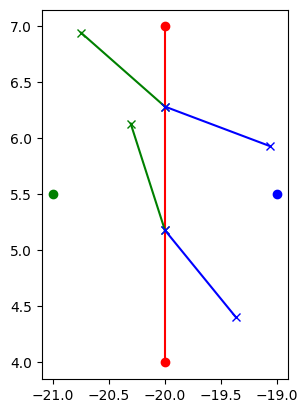

In [120]:
class Ray(object):
    def __init__(self, p: Point2D, a: float) -> None:
        self.point = p
        self.angle = a
        self.length = 1.0

    def getEndPoint(self) -> Point2D:
        return Point2D(
            self.point.x + (self.length * math.cos(math.radians(self.angle))),
            self.point.y + (self.length * math.sin(math.radians(self.angle))),
        )


# Min->Max angles
# 45 -> 135
# -135 -> -45
angled_rays: list[Ray] = []
angled_rays.append(Ray(Point2D(2.3788886, 3.3788888), 112.07376))
angled_rays.append(Ray(Point2D(1.6721303, 2.6721303), 74.06293))
angled_rays.append(Ray(Point2D(2.3788886, 3.3788888), -50.07376))
angled_rays.append(Ray(Point2D(1.6721303, 2.6721303), -130.06293))

plt.plot()
plot_line(line1, marker="o", color="red")

for ray in angled_rays:
    print(
        f"{ray.point.x},{ray.point.y} --> {ray.getEndPoint().x}, {ray.getEndPoint().y}"
    )
    plt.plot(
        [ray.point.x, ray.getEndPoint().x],
        [ray.point.y, ray.getEndPoint().y],
        marker="x",
        color="green",
    )

plt.scatter(
    [x.x for x in line1.ref_translated_normals],
    [y.y for y in line1.ref_translated_normals],
    marker="o",
)
ax = plt.gca()

# ax.set_xlim([-30, 10])
# ax.set_ylim([0, 8])
plt.gca().set_aspect("equal")
plt.show()


# These are the min and max angles produced--which are wrong?? Investigate...
# 90 -> 180
# -90 -> 0
straight_rays: list[Ray] = []
straight_rays.append(Ray(Point2D(-20, 5.181012), 107.801895))
straight_rays.append(Ray(Point2D(-20, 6.2847443), 138.6312))
straight_rays.append(Ray(Point2D(-20, 5.181012), -50.801895))
straight_rays.append(Ray(Point2D(-20, 6.2847443), -20.6312))

plt.plot()
plot_line(line2, marker="o", color="red")
count = 0
ray_color = "green"
for ray in straight_rays:
    if count > 1:
        ray_color = "blue"
    plt.plot(
        [ray.point.x, ray.getEndPoint().x],
        [ray.point.y, ray.getEndPoint().y],
        marker="x",
        color=ray_color,
    )

    count = count + 1

count = 0
normal_color = "green"
for n in line2.ref_translated_normals:
    if count > 0:
        normal_color = "blue"
    plt.scatter(n.x, n.y, marker="o", color=normal_color)
    count = count + 1

ax = plt.gca()

# ax.set_xlim([-30, 0])
# ax.set_ylim([0, 8])
plt.gca().set_aspect("equal")
plt.show()